Filter Performance Metrics:
Savitzky–Golay: SNR = 32.60 dB, RMSE = 2.5959
Moving Average: SNR = 26.76 dB, RMSE = 5.0223
Gaussian: SNR = 24.32 dB, RMSE = 6.5917
Butterworth: SNR = 29.38 dB, RMSE = 3.7593


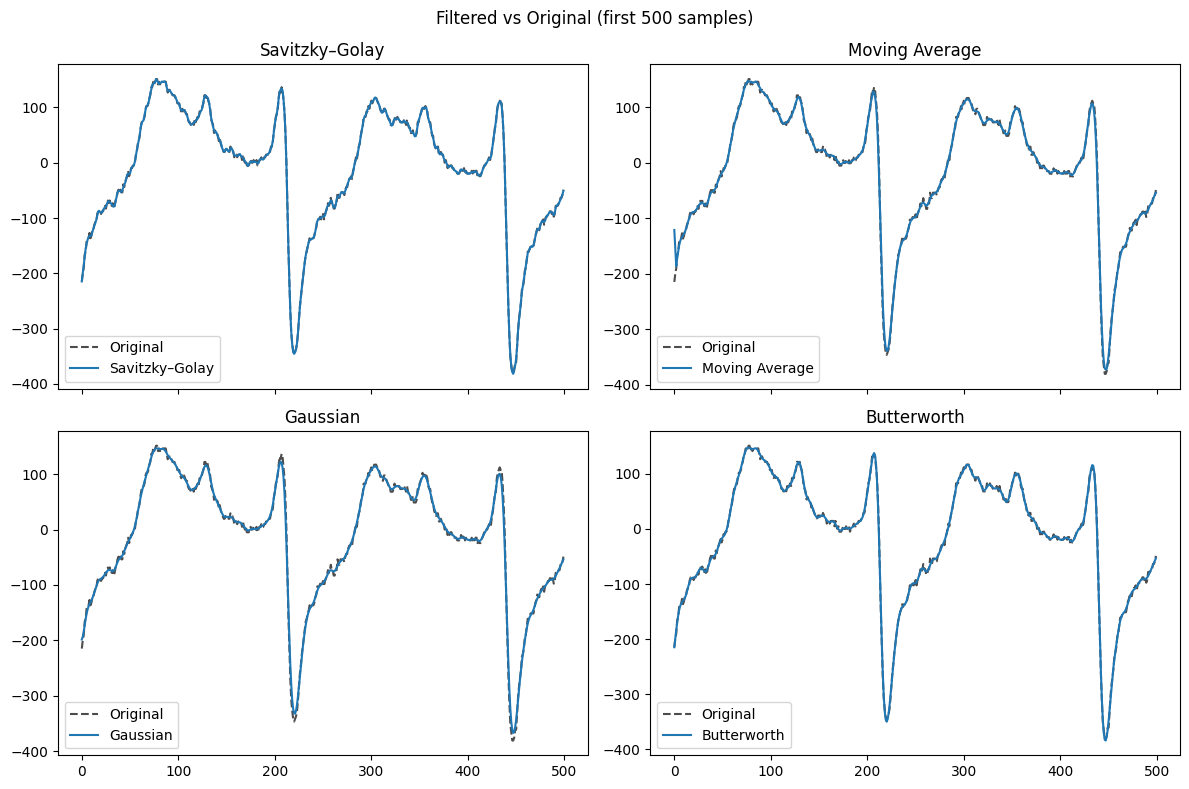

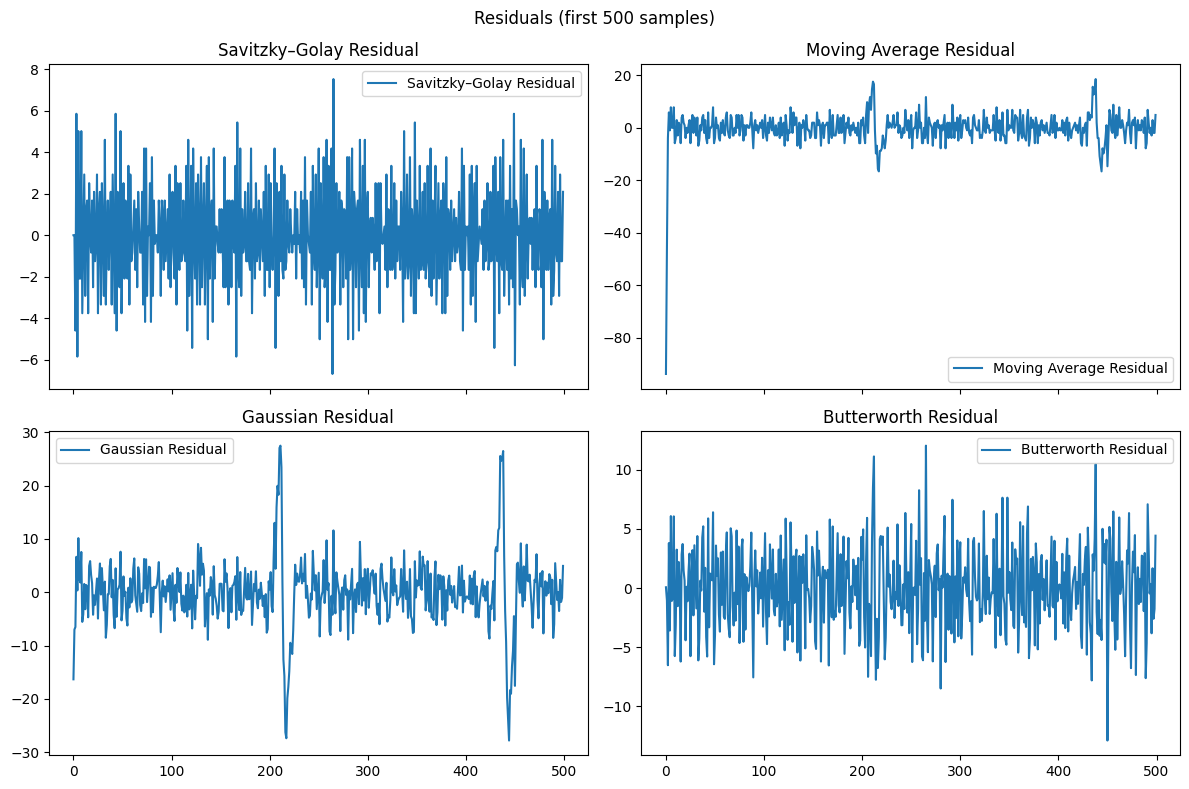

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d

def read_csv_multi(filename):
    channels = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: continue
            parts = line.split(',')
            try:
                values = [float(x) for x in parts]
            except ValueError:
                continue
            if not channels:
                channels = [[] for _ in range(len(values))]
            for i, v in enumerate(values):
                channels[i].append(v)
    return channels

def transpose_matrix(A):
    return list(map(list, zip(*A)))

def matrix_multiply(A, B):
    return [[sum(A[i][k]*B[k][j] for k in range(len(B))) for j in range(len(B[0]))] for i in range(len(A))]

def matrix_inverse(M):
    n = len(M)
    AM = [row[:] + [1.0 if i==j else 0.0 for j in range(n)] for i, row in enumerate(M)]
    # Gauss-Jordan
    for i in range(n):
        pivot = AM[i][i]
        if pivot == 0:
            for j in range(i+1, n):
                if AM[j][i] != 0:
                    AM[i], AM[j] = AM[j], AM[i]
                    pivot = AM[i][i]
                    break
        for j in range(2*n):
            AM[i][j] /= pivot
        for k in range(n):
            if k != i:
                factor = AM[k][i]
                for j in range(2*n):
                    AM[k][j] -= factor * AM[i][j]
    return [row[n:] for row in AM]

def savgol_coeffs(window_size, poly_order):
    m = (window_size - 1)//2
    A = [[(i-m)**k for k in range(poly_order+1)] for i in range(window_size)]
    AT = transpose_matrix(A)
    ATA = matrix_multiply(AT, A)
    invATA = matrix_inverse(ATA)
    # coefficients = first row of invATA * AT
    coeffs = []
    for j in range(window_size):
        x = j - m
        coeffs.append(sum(invATA[0][k] * (x**k) for k in range(poly_order+1)))
    return coeffs

def savgol_filter(signal, window_size, poly_order):
    m = (window_size - 1)//2
    coeffs = savgol_coeffs(window_size, poly_order)
    filtered = []
    N = len(signal)
    for i in range(N):
        if i < m or i >= N - m:
            filtered.append(signal[i])
        else:
            filtered.append(sum(coeffs[j] * signal[i-m+j] for j in range(window_size)))
    return np.array(filtered)

# --- Benchmark filters ---
def moving_average(sig, window_size=5):
    return np.convolve(sig, np.ones(window_size)/window_size, mode='same')

def gaussian_filter(sig, sigma=2):
    return gaussian_filter1d(sig, sigma)

def butterworth_filter(sig, cutoff=40, fs=360, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff/nyq, btype='low', analog=False)
    return filtfilt(b, a, sig)

# Metrics
def compute_snr(orig, filt):
    noise = orig - filt
    return 10 * np.log10(np.var(filt) / np.var(noise))

def compute_rmse(orig, filt):
    return np.sqrt(np.mean((orig - filt)**2))

# --- Main execution ---
filename = 'ECGData/MUSE_20180111_155115_19000.csv'
channels = read_csv_multi(filename)
signal = np.array(channels[0])

# Apply filters
window_size, poly_order = 5, 2
results = {
    'Savitzky–Golay': savgol_filter(signal, window_size, poly_order),
    'Moving Average': moving_average(signal, window_size),
    'Gaussian': gaussian_filter(signal, sigma=2),
    'Butterworth': butterworth_filter(signal, cutoff=40, fs=360, order=4)
}

# Compute metrics
print("Filter Performance Metrics:")
for name, filt_sig in results.items():
    snr = compute_snr(signal, filt_sig)
    rmse = compute_rmse(signal, filt_sig)
    print(f"{name}: SNR = {snr:.2f} dB, RMSE = {rmse:.4f}")

# Plot comparisons: each filter vs original (first 500 points)
t = np.arange(len(signal))
seg = slice(0, 500)
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
for ax, (name, filt_sig) in zip(axs.flatten(), results.items()):
    ax.plot(t[seg], signal[seg], 'k--', label='Original', alpha=0.7)
    ax.plot(t[seg], filt_sig[seg], label=name)
    ax.set_title(name)
    ax.legend()
fig.suptitle('Filtered vs Original (first 500 samples)')
plt.tight_layout()

# Plot residuals for each filter
fig2, axs2 = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
for ax, (name, filt_sig) in zip(axs2.flatten(), results.items()):
    res = signal[seg] - filt_sig[seg]
    ax.plot(t[seg], res, label=f'{name} Residual')
    ax.set_title(f'{name} Residual')
    ax.legend()
fig2.suptitle('Residuals (first 500 samples)')
plt.tight_layout()

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import time
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d

def read_csv_multi(filename):
    channels = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: continue
            parts = line.split(',')
            try:
                values = [float(x) for x in parts]
            except ValueError:
                continue
            if not channels:
                channels = [[] for _ in range(len(values))]
            for i, v in enumerate(values):
                channels[i].append(v)
    return channels

def transpose_matrix(A):
    return list(map(list, zip(*A)))

def matrix_multiply(A, B):
    return [[sum(A[i][k]*B[k][j] for k in range(len(B))) for j in range(len(B[0]))] for i in range(len(A))]

def matrix_inverse(M):
    n = len(M)
    AM = [row[:] + [1.0 if i==j else 0.0 for j in range(n)] for i, row in enumerate(M)]
    # Gauss-Jordan
    for i in range(n):
        pivot = AM[i][i]
        if pivot == 0:
            for j in range(i+1, n):
                if AM[j][i] != 0:
                    AM[i], AM[j] = AM[j], AM[i]
                    pivot = AM[i][i]
                    break
        for j in range(2*n):
            AM[i][j] /= pivot
        for k in range(n):
            if k != i:
                factor = AM[k][i]
                for j in range(2*n):
                    AM[k][j] -= factor * AM[i][j]
    return [row[n:] for row in AM]

def savgol_coeffs(window_size, poly_order):
    m = (window_size - 1)//2
    A = [[(i-m)**k for k in range(poly_order+1)] for i in range(window_size)]
    AT = transpose_matrix(A)
    ATA = matrix_multiply(AT, A)
    invATA = matrix_inverse(ATA)
    # coefficients = first row of invATA * AT
    coeffs = []
    for j in range(window_size):
        x = j - m
        coeffs.append(sum(invATA[0][k] * (x**k) for k in range(poly_order+1)))
    return coeffs

def savgol_filter(signal, window_size, poly_order):
    m = (window_size - 1)//2
    coeffs = savgol_coeffs(window_size, poly_order)
    filtered = []
    N = len(signal)
    for i in range(N):
        if i < m or i >= N - m:
            filtered.append(signal[i])
        else:
            filtered.append(sum(coeffs[j] * signal[i-m+j] for j in range(window_size)))
    return np.array(filtered)


# Benchmark filters
def moving_average(sig, window_size=5):
    return np.convolve(sig, np.ones(window_size)/window_size, mode='same')

def gaussian_filter(sig, sigma=2):
    return gaussian_filter1d(sig, sigma)

def butterworth_filter(sig, cutoff=40, fs=360, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff/nyq, btype='low', analog=False)
    return filtfilt(b, a, sig)

# Metrics
def compute_snr(orig, filt):
    noise = orig - filt
    return 10 * np.log10(np.var(filt) / np.var(noise))

def compute_rmse(orig, filt):
    return np.sqrt(np.mean((orig - filt)**2))

# Load data
filename = 'ECGData/MUSE_20180111_155115_19000.csv'
channels = read_csv_multi(filename)
signal = np.array(channels[0])

# Set up filters
filters = {
    'Savitzky–Golay': lambda sig: savgol_filter(sig, window_size=5, poly_order=2),
    'Moving Average': lambda sig: moving_average(sig, window_size=5),
    'Gaussian': lambda sig: gaussian_filter(sig, sigma=2),
    'Butterworth': lambda sig: butterworth_filter(sig, cutoff=40, fs=360, order=4)
}

# Run benchmarks
results = []
for name, func in filters.items():
    start = time.time()
    filtered = func(signal)
    elapsed_ms = (time.time() - start) * 1000
    snr = compute_snr(signal, filtered)
    rmse = compute_rmse(signal, filtered)
    results.append({
        'Method': name,
        'SNR (dB)': round(snr, 2),
        'RMSE': round(rmse, 4),
        'Time (ms)': round(elapsed_ms, 2)
    })

df = pd.DataFrame(results)
print(df.to_string(index=False))


        Method  SNR (dB)   RMSE  Time (ms)
Savitzky–Golay     32.60 2.5959       8.59
Moving Average     26.76 5.0223       0.09
      Gaussian     24.32 6.5917       0.27
   Butterworth     29.38 3.7593       0.93
